In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function

import numpy as np
import tempfile

import rocnnet.rocnnet as rcn

from tf_rl.controller import HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate


In [3]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/var/folders/fs/cfs_ql391csfpxfsdxhmktw00000gn/T/tmph9LivF


In [4]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 0.1,
        'enemy': -0.1,
    },
    'hero_bounces_off_walls': False,
    'world_size': (700,500),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0,   0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_objects": {
        "friend" : 25,
        "enemy" :  25,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 120.,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -0.0,
    "delta_v": 50
}

In [5]:
# create the game simulator
g = KarpathyGame(current_settings)

In [9]:
class DQNControllerWrapper:
    def __init__(self, trainer):
        self.trainer = trainer

    def action(self, o):
        return self.trainer.action(o)

    def store(self, observation, action, reward, newobservation):
        self.trainer.store(observation, action, reward, newobservation)

    def training_step(self):
        self.trainer.train()

In [10]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    hiddens = [
        rcn.get_layer(rcn.tanh, 200),
        rcn.get_layer(rcn.tanh, 200),
        rcn.get_layer(rcn.identity, g.num_actions)
    ]
    brain = rcn.get_mlp(g.observation_size, hiddens, 'brain')
    
    # todo: use rms_prop instead
    bgd = rcn.get_rms_momentum(
        learning_rate = 0.001,
        discount_factor = 0.9)
    
    param = rcn.get_dqninfo(
        discount_rate = 0.99,
        exploration_period = 5000,
        max_exp = 1000,
        store_interval = 4,
        train_interval = 4)
    
    current_controller = DQNControllerWrapper(rcn.DQNTrainer(brain, bgd, param))

In [11]:
FPS          = 30
ACTION_EVERY = 3
    
# fast_mode = True
fast_mode = False
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 50
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    simulate(
        simulation=g,
        controller=current_controller,
        fps=FPS,
        visualize_every=VISUALIZE_EVERY,
        action_every=ACTION_EVERY,
        wait=WAIT,
        disable_training=False,
        simulation_resolution=0.001,
        save_path=None)
except KeyboardInterrupt:
    print("Interrupted")

<tf_rl.utils.svg.Scene instance at 0x11b57e1b8>

training...
Interrupted


In [17]:
current_controller.q_network.input_layer.Ws[0].eval()

array([[-2.3352800e-02, -3.3744633e-02, -1.8467724e-02, ...,
        -1.0163245e-01, -8.9376166e-02,  1.9391297e-01],
       [ 5.6610625e-02, -3.2229971e-02,  1.4173320e-04, ...,
         1.1005688e-01,  4.3640941e-02, -9.3772806e-02],
       [-1.9736649e-02,  5.3174034e-02,  2.2331353e-02, ...,
        -6.6780613e-04,  1.0842143e-01, -1.4250801e-02],
       ...,
       [-1.8170854e-02,  3.1113336e-02, -3.2956293e-04, ...,
         2.5987414e-01,  4.4155620e-02,  2.0988025e-02],
       [ 5.1289115e-02,  3.6625866e-02, -9.0763420e-02, ...,
        -1.4920431e-01, -1.3197160e-01,  4.3390091e-03],
       [-1.9088745e-02,  4.3516390e-02, -1.1606047e-02, ...,
        -1.8046102e-01,  8.2466369e-03, -9.1706492e-02]], dtype=float32)

In [18]:
current_controller.target_q_network.input_layer.Ws[0].eval()

array([[-0.0232094 , -0.03470997, -0.01932178, ..., -0.10196902,
        -0.08936045,  0.19325916],
       [ 0.0565188 , -0.03227952,  0.00038817, ...,  0.10950922,
         0.04346081, -0.09394554],
       [-0.01929909,  0.05275653,  0.02215372, ..., -0.00095728,
         0.10832175, -0.01446874],
       ...,
       [-0.02120609,  0.03246776, -0.00131016, ...,  0.25351545,
         0.03821909,  0.01896506],
       [ 0.05542298,  0.03707531, -0.08753664, ..., -0.14265831,
        -0.12674141,  0.00818704],
       [-0.02101831,  0.04323026, -0.01235394, ..., -0.17966184,
         0.00984171, -0.09566692]], dtype=float32)

# Average Reward over time

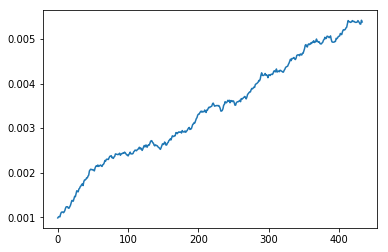

In [19]:
g.plot_reward(smoothing=100)

In [21]:
current_controller.q_network.input_layer.Ws[0].eval()

array([[-2.3352800e-02, -3.3744633e-02, -1.8467724e-02, ...,
        -1.0163245e-01, -8.9376166e-02,  1.9391297e-01],
       [ 5.6610625e-02, -3.2229971e-02,  1.4173320e-04, ...,
         1.1005688e-01,  4.3640941e-02, -9.3772806e-02],
       [-1.9736649e-02,  5.3174034e-02,  2.2331353e-02, ...,
        -6.6780613e-04,  1.0842143e-01, -1.4250801e-02],
       ...,
       [-1.8170854e-02,  3.1113336e-02, -3.2956293e-04, ...,
         2.5987414e-01,  4.4155620e-02,  2.0988025e-02],
       [ 5.1289115e-02,  3.6625866e-02, -9.0763420e-02, ...,
        -1.4920431e-01, -1.3197160e-01,  4.3390091e-03],
       [-1.9088745e-02,  4.3516390e-02, -1.1606047e-02, ...,
        -1.8046102e-01,  8.2466369e-03, -9.1706492e-02]], dtype=float32)

In [22]:
current_controller.target_q_network.input_layer.Ws[0].eval()

array([[-0.02321083, -0.03470032, -0.01931324, ..., -0.10196565,
        -0.08936061,  0.1932657 ],
       [ 0.05651972, -0.03227903,  0.00038571, ...,  0.1095147 ,
         0.04346261, -0.09394381],
       [-0.01930346,  0.05276071,  0.0221555 , ..., -0.00095438,
         0.10832275, -0.01446656],
       ...,
       [-0.02117574,  0.03245422, -0.00130035, ...,  0.25357905,
         0.03827846,  0.01898529],
       [ 0.05538164,  0.03707081, -0.08756891, ..., -0.14272377,
        -0.12679371,  0.00814856],
       [-0.02099901,  0.04323312, -0.01234647, ..., -0.17966983,
         0.00982576, -0.09562731]], dtype=float32)

# Visualizing what the agent is seeing

Starting with the ray pointing all the way right, we have one row per ray in clockwise order.
The numbers for each ray are the following:
- first three numbers are normalized distances to the closest visible (intersecting with the ray) object. If no object is visible then all of them are $1$. If there's many objects in sight, then only the closest one is visible. The numbers represent distance to friend, enemy and wall in order.
- the last two numbers represent the speed of moving object (x and y components). Speed of wall is ... zero.

Finally the last two numbers in the representation correspond to speed of the hero.

In [23]:
g.__class__ = KarpathyGame
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-4].shape[0]//g.eye_observation_size, g.eye_observation_size)
print(x[:-4].reshape(new_shape))
print(x[-4:])
g.to_html()

[[1.00 1.00 0.93 0.00 0.00]
 [1.00 1.00 0.94 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 0.82 1.00 0.83 0.07]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [0.62 1.00 1.00 -0.38 -0.41]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 0.93 1.00 0.15 -0.08]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 0.65 1.00 0.04 0.68]
 [1.00 1.00 1.00 0.00 0.00]
 [0.51 1.00 1.00 -0.69 -0.30]
 [0.48 1.00 1.00 -0.69 -0.30]]
[0.01 1.99 0.68 -0.31]


<tf_rl.utils.svg.Scene instance at 0x126ee4290>